In [2]:
%load_ext autoreload
%autoreload 2
from evaluation.face_recognition_test import Face_Fecognition_test
from evaluation.ijb_evals import instantiate_list
from omegaconf import OmegaConf
from pathlib import Path
import numpy as np
from evaluation.visualize import (
    plot_dir_far_scores,
    plot_cmc_scores,
    plot_rejection_scores,
)
from evaluation.confidence_functions import MisesProb
from hydra.utils import instantiate

In [3]:
cfg = OmegaConf.load("/app/configs/uncertainty_benchmark/ijb_evals.yaml")
method = cfg.open_set_identification_methods[0]
sampler = instantiate(method.sampler)
evaluation_function = instantiate(method.evaluation_function)
assert evaluation_function is not None
# if cfg.test_dataset.dataset_name == "survFace" and method.use_detector_score:
#     continue
template_pooling = instantiate(method.template_pooling_strategy)

In [4]:
open_set_identification_metrics = instantiate_list(cfg.open_set_identification_metrics)
if "open_set_uncertainty_metrics" in cfg:
    open_set_uncertainty_metrics = instantiate_list(cfg.open_set_uncertainty_metrics)
else:
    open_set_uncertainty_metrics = []

test_dataset = instantiate(cfg.test_dataset)

# create result dirs:
dataset_name = cfg.test_dataset.dataset_name
open_set_identification_result_dir = (
    Path(cfg.exp_dir) / dataset_name / "open_set_identification"
)
open_set_identification_result_dir.mkdir(exist_ok=True, parents=True)

tt = Face_Fecognition_test(
    sampler=sampler,
    evaluation_function=evaluation_function,
    test_dataset=test_dataset,
    embeddings_path=method.embeddings_path,
    template_pooling_strategy=template_pooling,
    use_detector_score=method.use_detector_score,
    use_two_galleries=cfg.use_two_galleries,
    recompute_template_pooling=cfg.recompute_template_pooling,
    open_set_identification_metrics=open_set_identification_metrics,
    closed_set_identification_metrics=None,
    verification_metrics=None,
    open_set_uncertainty_metrics=open_set_uncertainty_metrics,
)

In [5]:
(
    g1_templates_feature,
    g1_template_unc,
    g1_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.g1_templates, tt.test_dataset.g1_ids)

(
    probe_templates_feature,
    probe_template_unc,
    probe_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.probe_templates, tt.test_dataset.probe_ids)

# sample probe feature vectors

probe_templates_feature = tt.sampler(
    probe_templates_feature,
    probe_template_unc,
)

In [6]:
similarity, probe_score = tt.evaluation_function(
    probe_templates_feature,
    probe_template_unc,
    g1_templates_feature,
    g1_template_unc,
)

In [7]:
similarity.shape

(19593, 1, 1772)

In [8]:
gallery_ids = g1_unique_ids
gallery_ids_argsort = np.argsort(gallery_ids)
gallery_ids_sorted = gallery_ids[gallery_ids_argsort]

In [21]:
gallery_ids_sorted_von_mises = np.concatenate([gallery_ids_sorted, [-1]]) # last id is for out of gallery

def compute_von_Mises_tar_far(kappa, beta, probe_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort,gallery_ids_sorted, similarity, present_probe_ids):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids)
    seen_probe_ids = selected_probe_ids[is_seen]
    mises_maxprob = MisesProb(kappa=kappa, beta=beta)
    all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
                selected_similarity
            )
    all_classes_log_prob = all_classes_log_prob[:, 0, :]

    # make pred
    # sort labels
    all_classes_log_prob[:, :-1] = all_classes_log_prob[:, :-1][:, gallery_ids_argsort]
    predict_id = np.argmax(all_classes_log_prob, axis=-1)
    # far
    far = np.mean(predict_id[~is_seen]!=similarity.shape[-1])
    # tar
    tar = np.mean(gallery_ids_sorted_von_mises[predict_id[is_seen]] == seen_probe_ids)
    
    false_ident_num = np.sum(np.logical_and(gallery_ids_sorted_von_mises[predict_id[is_seen]] != seen_probe_ids,
                                            predict_id[is_seen]!=similarity.shape[-1]))
    most_similar_classes = np.argmax(all_classes_log_prob[:, :-1], axis=-1)[is_seen]
    similar_class = gallery_ids_sorted[most_similar_classes]
    false_ident_num_v2 = np.sum(seen_probe_ids != similar_class)## is that right?

    false_accept_num = np.sum(predict_id[~is_seen]!=similarity.shape[-1])
    false_reject_num = np.sum(predict_id[is_seen]==similarity.shape[-1])
    return tar, far, false_ident_num, false_ident_num_v2, false_accept_num, false_reject_num
    

In [22]:
present_probe_ids = np.arange(probe_unique_ids.shape[0])
kappa = 540.0
beta = 0.9772372209558107
compute_von_Mises_tar_far(kappa, beta, probe_unique_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, gallery_ids_sorted, similarity, present_probe_ids)

(0.9445708376421923, 0.010178373475763378, 13, 269, 101, 523)

In [26]:
from itertools import product
from tqdm import tqdm
kappas = np.linspace(100,1200,6)
betas = np.logspace(-0.01, -0.01, num=1)
print(len(kappas) * len(betas))
kappa_beta_to_tar_far = {}
present_probe_ids = np.arange(probe_unique_ids.shape[0])
for kappa, beta in tqdm(product(kappas, betas), total=len(kappas) * len(betas)):
    tar, far, _, _, _, _ = compute_von_Mises_tar_far(kappa, beta, probe_unique_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, gallery_ids_sorted, similarity, present_probe_ids)
    #print(f'tar-{tar} at far-{far} with kappa-{kappa} and beta {beta}')
    kappa_beta_to_tar_far[(kappa, beta)] = (tar, far)

  0%|          | 0/6 [00:00<?, ?it/s]

6


 50%|█████     | 3/6 [00:09<00:09,  3.12s/it]/app/evaluation/confidence_functions.py:52: RuntimeWarning: overflow encountered in exp
  np.sum(np.exp(similarities * self.kappa), axis=-1) * (1 - self.beta) / K
100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


In [27]:
tars = np.array([kappa_beta_to_tar_far[key][0] for key in kappa_beta_to_tar_far])
fars = np.array([kappa_beta_to_tar_far[key][1] for key in kappa_beta_to_tar_far])

far_sort_idx = np.argsort(fars)
fars = fars[far_sort_idx]
tars = tars[far_sort_idx]

In [28]:
a = np.load('/app/outputs/experiments/open_set_uncertainty_without_thresh/IJBC/open_set_identification/Cosine_recalls_1_rank.npz')

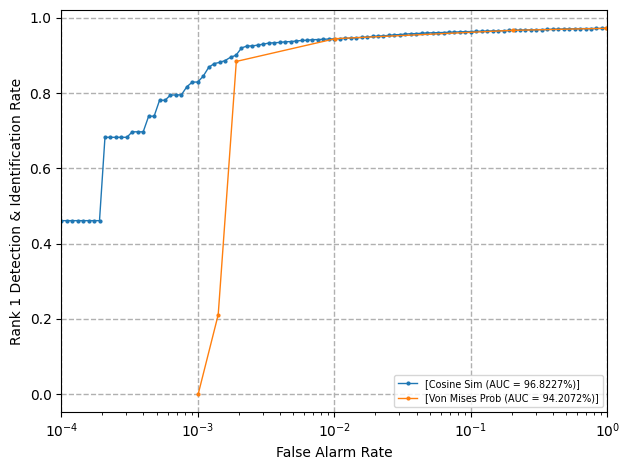

In [29]:
scores = [(a['fars'], a['recalls']) , (fars, tars)]
model_names = ['Cosine Sim', 'Von Mises Prob']
fig = plot_dir_far_scores(
            scores=scores,
            names=model_names,
            y_label=f"Rank 1 Detection & Identification Rate",
            marker='o'
        )
fig.savefig(f"dir_plot.png", dpi=300)

### Perform rejection based on uncertanty for a fixed algorithm (fixed threshold or kappa)

First we fix parametr of algorithm, so it have far=0.01

In [30]:
kappa = 540.0
beta = 0.9772372209558107

In [31]:
cosine_far = 0.010178373475763378 # far of von Mises at kappa = 540.0, beta = 0.9772372209558107
# compute operating threshold τ, which gives neaded far
is_seen = np.isin(probe_unique_ids, gallery_ids)
neg_score = probe_score[~is_seen]
pos_score = probe_score[is_seen]
neg_score_sorted = np.sort(neg_score)[::-1]
if len(neg_score_sorted) == 0:
    thresh = -np.inf
else:
    thresh = neg_score_sorted[
        max(int((neg_score_sorted.shape[0]) * cosine_far) - 1, 0)
    ]

In [32]:
thresh

0.4121742600157263

In [33]:
def compute_cosine_tar_far(thresh, probe_ids, gallery_ids_sorted, probe_score, similarity, present_probe_ids, rank=1):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_probe_scores = probe_score[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids_sorted)
    seen_sim: np.ndarray = selected_similarity[is_seen]
    neg_score = selected_probe_scores[~is_seen]
    pos_score = selected_probe_scores[is_seen]
    seen_probe_ids = selected_probe_ids[is_seen]
    most_similar_classes = np.argmax(seen_sim, axis=1)
    similar_class = gallery_ids_sorted[most_similar_classes]
    correct_pos = (seen_probe_ids == similar_class)
    tar = (
            np.sum(np.logical_and(correct_pos, pos_score > thresh))
            / seen_probe_ids.shape[0]
        )
    far = np.mean(neg_score>thresh)
    false_ident_num = seen_probe_ids.shape[0] - np.sum(correct_pos)
    false_accept_num = np.sum(neg_score>thresh)
    false_reject_num = np.sum(pos_score < thresh)
    return tar, far, false_ident_num, false_accept_num, false_reject_num
    

In [34]:
similarity_sorted = similarity[:,0, gallery_ids_argsort]
present_probe_ids = np.arange(probe_unique_ids.shape[0])
compute_cosine_tar_far(thresh, probe_unique_ids, gallery_ids_sorted, probe_score, similarity_sorted, present_probe_ids)

(0.944364012409514, 0.01007759750075582, 269, 100, 525)

In [36]:
mises_maxprob = MisesProb(kappa=kappa, beta=beta)
all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
            similarity
        )
all_classes_log_prob = all_classes_log_prob[:, 0, :]
prob_unc = -np.max(all_classes_log_prob, axis=1)
entr_unc = -np.sum(np.exp(all_classes_log_prob)*all_classes_log_prob, axis=1)
scf_unc = -probe_template_unc[:,0]
simple_maxprob = np.max(similarity[:,0,:], axis=1)
simple_maxprob_norm = (probe_score + 1) / 2
be_unc = simple_maxprob_norm * (1 - simple_maxprob_norm)

In [37]:
# import seaborn as sns
# sns.distplot(
#     be_unce,
#     kde=True,
#     norm_hist=True,
#     hist=True,
#     label='maxprob',
# )

In [48]:
fractions = np.linspace(0, 0.2, 10)
probe_sorted_by_scf_unc = np.argsort(scf_unc)
probe_sorted_by_prob_unc = np.argsort(prob_unc)
probe_sorted_by_be_unc = np.argsort(be_unc)
methods = ['scf', 'be', 'prob','scf+prob']
rejection_tar_far = {name: {'tars':[], 'fars':[]} for name in methods}
rejection_error_count = {name: {'false_accept':[], 'false_reject':[], 'false_ident': []} for name in methods}
for fraction in tqdm(fractions):
    good_probes_idx_scf = probe_sorted_by_scf_unc[: int((1 - fraction) * probe_unique_ids.shape[0])]
    good_probes_idx_prob = probe_sorted_by_prob_unc[: int((1 - fraction) * probe_unique_ids.shape[0])]
    good_probes_idx_be = probe_sorted_by_be_unc[: int((1 - fraction) * probe_unique_ids.shape[0])]
    scf_tar, scf_far, scf_false_ident_num, scf_false_accept_num, scf_false_reject_num = compute_cosine_tar_far(thresh, probe_unique_ids, gallery_ids_sorted, probe_score, similarity_sorted, good_probes_idx_scf)
    be_tar, be_far, be_false_ident_num, be_false_accept_num, be_false_reject_num = compute_cosine_tar_far(thresh, probe_unique_ids, gallery_ids_sorted, probe_score, similarity_sorted, good_probes_idx_be)
    rejection_tar_far['scf']['tars'].append(scf_tar)
    rejection_tar_far['scf']['fars'].append(scf_far)
    rejection_error_count['scf']['false_accept'].append(scf_false_accept_num)
    rejection_error_count['scf']['false_reject'].append(scf_false_reject_num)
    rejection_error_count['scf']['false_ident'].append(scf_false_ident_num)
    rejection_tar_far['be']['tars'].append(be_tar)
    rejection_tar_far['be']['fars'].append(be_far)
    rejection_error_count['be']['false_accept'].append(be_false_accept_num)
    rejection_error_count['be']['false_reject'].append(be_false_reject_num)
    rejection_error_count['be']['false_ident'].append(be_false_ident_num)
    prob_tar, prob_far, _, prob_false_ident_num, prob_false_accept_num, prob_false_reject_num = compute_von_Mises_tar_far(kappa, beta, probe_unique_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, gallery_ids_sorted, similarity, good_probes_idx_prob)
    rejection_tar_far['prob']['tars'].append(prob_tar)
    rejection_tar_far['prob']['fars'].append(prob_far)
    rejection_error_count['prob']['false_accept'].append(prob_false_accept_num)
    rejection_error_count['prob']['false_reject'].append(prob_false_reject_num)
    rejection_error_count['prob']['false_ident'].append(prob_false_ident_num)

 60%|██████    | 6/10 [00:27<00:18,  4.50s/it]

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


In [40]:
1

1

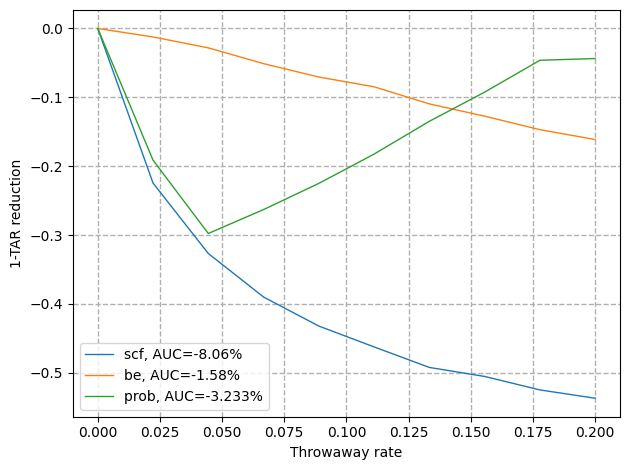

In [41]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_tar_far:
    tars = rejection_tar_far[method_name]['tars']
    tars = np.array(tars)
    if len(tars) == 0:
        continue
    scores.append((fractions, ((1-tars) - (1-tars[0]))/(1-tars[0])))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"1-TAR reduction",
)
fig.savefig(f"tar_rejection.png", dpi=300)

In [ ]:
1

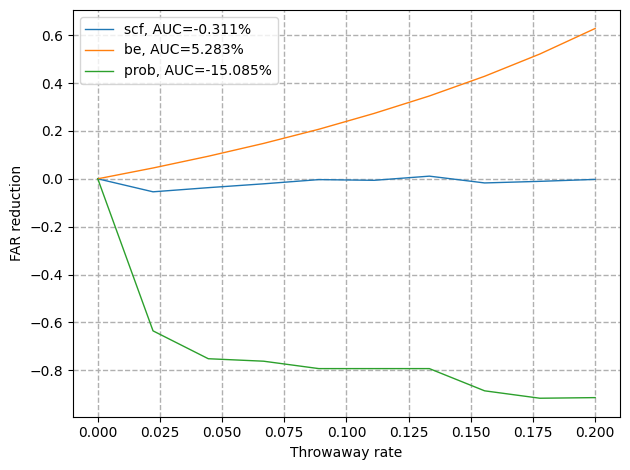

In [42]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_tar_far:
    fars = rejection_tar_far[method_name]['fars']
    fars = np.array(fars)
    if len(fars) == 0:
        continue
    scores.append((fractions, ((fars) - (fars[0]))/(fars[0])))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"FAR reduction",
)
fig.savefig(f"tar_rejection.png", dpi=300)

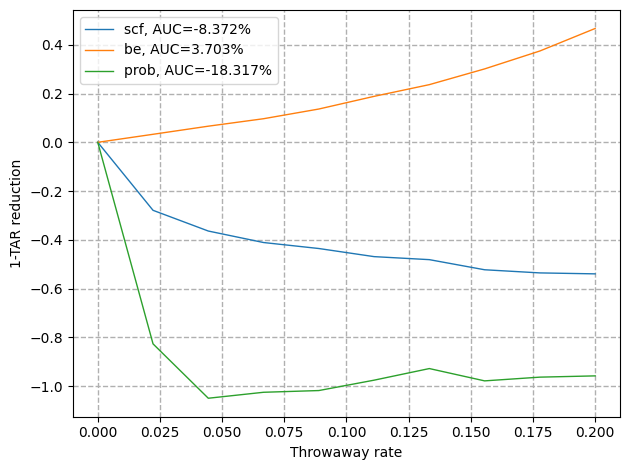

In [43]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_tar_far:
    tars = rejection_tar_far[method_name]['tars']
    tars = np.array(tars)
    fars = rejection_tar_far[method_name]['fars']
    fars = np.array(fars)
    if len(fars) == 0:
        continue
    scores.append((fractions, ((1-tars) - (1-tars[0]))/(1-tars[0]) +  ((fars) - (fars[0]))/(fars[0])))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"1-TAR reduction",
)
fig.savefig(f"tar_rejection.png", dpi=300)

### Let's see how number of different error types changes

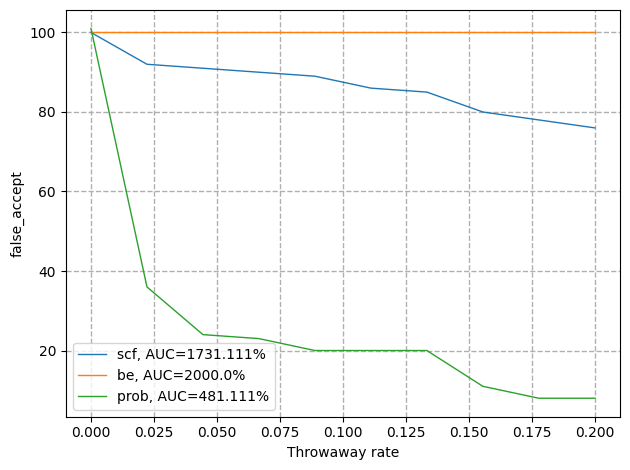

In [49]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_error_count:
    false_accept = rejection_error_count[method_name]['false_accept']
    false_accept = np.array(false_accept)
    if len(false_accept) == 0:
        continue
    scores.append((fractions, false_accept))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_accept",
)
fig.savefig(f"false_accept.png", dpi=300)

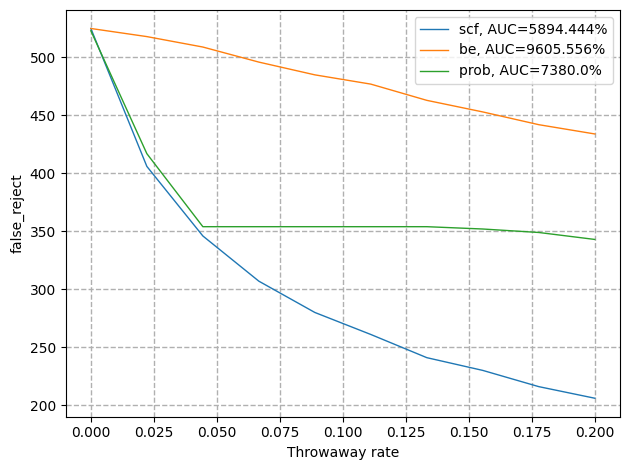

In [50]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_error_count:
    false_reject = rejection_error_count[method_name]['false_reject']
    false_reject = np.array(false_reject)
    if len(false_reject) == 0:
        continue
    scores.append((fractions, false_reject))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_reject",
)
fig.savefig(f"false_reject.png", dpi=300)

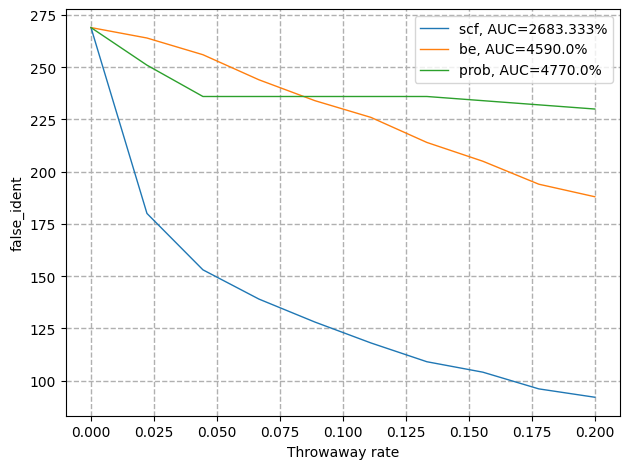

In [51]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_error_count:
    false_ident = rejection_error_count[method_name]['false_ident']
    false_ident = np.array(false_ident)
    if len(false_ident) == 0:
        continue
    scores.append((fractions, false_ident))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_ident",
)
fig.savefig(f"false_ident.png", dpi=300)

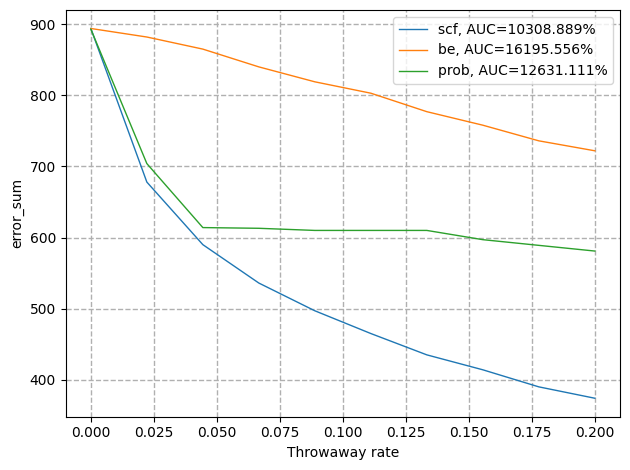

In [52]:
from evaluation.visualize import plot_rejection_scores
scores = []
names = []
for method_name in rejection_error_count:
    false_ident = rejection_error_count[method_name]['false_ident']
    false_ident = np.array(false_ident)
    false_reject = rejection_error_count[method_name]['false_reject']
    false_reject = np.array(false_reject)
    false_accept = rejection_error_count[method_name]['false_accept']
    false_accept = np.array(false_accept)
    if len(false_ident) == 0:
        continue
    scores.append((fractions, false_accept+false_ident+false_reject))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"error_sum",
)
fig.savefig(f"error_sum.png", dpi=300)

In [46]:
false_accept

array(76)

In [47]:
method_name

'scf'